# Progetto: Hotel Bookings

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Studente: Alessandro Lombardini  
alessandr.lombardin3@unibo.it


In [216]:
# Setup librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## Caso di studio

- Data una prenotazione di un cliente presso un hotel, si vuole valutare se questa verrà cancellata
- Da ciascuna prenotazione possono essere estratte delle caratteristiche
  - numero di adulti, giorno di arrivo, numero di posti auto richiesti, ...
- Vogliamo addestrare un modello a classificare ciascuna prenotazione sulla base di queste caratteristiche

- Utilizziamo [Hotel booking demand](https://www.kaggle.com/jessemostipak/hotel-booking-demand), in cui ogni osservazione contiene le caratteristiche estratte da una prenotazione
- Con `read_csv` possiamo importare il dataset direttamente in un frame pandas dato il suo URL

In [217]:
HBD_URL = "https://bitbucket.org/alessandrolombardini/hotel-bookings/raw/d5130f7e47e3e943886c1ab5266197202e6fe9af/hotel_bookings.csv"
hbd_complete = pd.read_csv(HBD_URL)

In [218]:
hbd_complete.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


- `Hotel booking demand` prevede al suo interno due dataset, uno per _Resort Hotel_ e uno per _City Hotel_. Entrambi i dataset condividono la stessa struttura, e comprendono prenotazioni effettuate dal 1 Luglio 2015 al 31 Agosto 2017. Poichè questi sono dati reali, tutti i dati personali dei clienti sono stati eliminati oppore sostiuiti con identificativi anonimi. 

- Si tratta di classificazione binaria, ovvero con due possibili classi
- La colonna `is_canceled` indica la classificazione delle prenotazioni 
    - 0 = non cancellata, 1 = cancellata
- Le altre 31 colonne corrispondono alle altre variabili estratte dalla prenotazione

- Il dataset presenta le seguenti dimensioni:
    - 119390 istanze 
    - 32 feature

In [219]:
hbd_complete.shape

(119390, 32)

### Lista delle variabili

- `hotel`: hotel prenotato dal cliente (H1 = Resort Hotel o H2 = City Hotel)
- `lead_time`: numero di giorni che intercorrono dal giorno di prenotazione al giorno di arrivo in hotel del cliente
- `arrival_date_year`: anno di arrivo del cliente in hotel
- `arrival_date_month`: mese di arrivo del cliente in hotel
- `arrival_date_week_number`: numero della settimana dell'anno di arrivo del cliente in hotel
- `arrival_date_day_of_month`: numero del giorno del mese di arrivo del cliente in hotel
- `stays_in_weekend_nights`: numero di notti di finesettimana (Sabato e Domenica) prenotate del cliente
- `stays_in_week_nights`:  numero di notti non di finesettimana (da Lunedi a Venerdi) prenotate del cliente
- `adults`: numero di adulti 
- `children`: numero di bambini 
- `babies`: numero di neonati
- `meal`: pacchetto pasti richiesto dal cliente
    - Undefined/SC – nessuno pacchetto
    - BB – Bed & Breakfast 
    - HB – Mezza pensione (colazione ed un altro pasto – solitamente cena); 
    - FB – Pensione completa (colazione, pranzo e cena)
- `country`: stato di provenienza
- `market_segment`: segmento di mercato associato alla prenotazione (utile per raggruppare le prenotazioni in gruppi, al fine di adottare stategie di marketing adeguate)
- `distribution_channel`: canale per tramite del quale il cliente ha effettuato la prenotazione (TA/TO: il cliente si è appoggiato ad un agente di viaggio, Direct: la prenotazione è stata fatta dal cliente direttamente, ed altri)
- `is_repeated_guest`: indica se la prenotazione è fatta da un cliente che aveva già prenotato in passato
    - 1: Si, aveva già prenotato
    - 0: No, non aveva mai prenotato
- `previous_cancellations`: numero di prenotazioni cancellate in passato dal cliente
- `previous_bookings_not_canceled`: numero di prenotazioni effettuate in passato dal cliente e non cancellate
- `reserved_room_type`: codice del tipo di stanza richiesta dal cliente
- `assigned_room_type`: codice del tipo di stanza assegnata alla prenotazione. A volte vengono assegnate stanze diverse da quelle riservate per motivi legati all'Hotel (es. overbooking) o per richiesta del cliente. 
- `booking_changes`: numero di cambiamenti apportati alla prenotazione fino al momento del Check-In o della cancellazione
- `deposit_type`: indica se il cliente ha effettuato un deposito per garantirsi la prenotazione
    - No Deposit: nessun deposito è stato fatto
    - Non Refund: è stato pagato l'intero importo del soggiorno
    - Refundable: è stata pagata solo una parte dell'importo dell'intero soggiorno
- `agent`: ID dell'agente di viaggio che ha effettuato la prenotazione
- `company`: ID della compagnia che ha effettuato la prenotazione o che ha pagato la prenotazione. 
- `days_in_waiting_list`: numero di giorni in cui la prenotazione è rimasta in lista di attesa prima di essere confermata al cliente
- `customer_type`: tipologia di prenotazione
    - Contract: la prenotazione è associata ad un contratto
    - Group: la prenotazione è associata ad un gruppo
    - Transient: la prenotazione non è parte ne di un gruppo ne di un contratto, e non è associata ad altre prenotazione Transient 
    - Transient-party: la prenotazione è Transient ed è associata ad altre prenotazioni Transient (Transient è un termine utilizzato per indicare quelle prenotazioni effettuate da soggetti prevalentemente in movimento che effettuano brevi soggiorni in hotel, spesso last minute)
- `adr`: Avarage Daily Rate, definito come il costo del soggiorno diviso il numero di notti
- `required_car_parking_spaces`: numero di spazi macchina richiesti dal cliente
- `total_of_special_requests`: numero di richieste speciali effettuate dal cliente
- `reservation_status`: ultimo stato registrato della prenotazione
    - Canceled: la prenotazione è stata cancellata dal cliente
    - Check-Out: il client ha effettuato il Check-In e la sua permanenza è terminata
    - No-Show: il cliente non ha effettuato il Check-In e ha informato l'hotel del motivo
- `reservation_status_date`: data dell'ultima modifica alla variabile `reservation_status` 
- **`is_canceled`**: indica se la prenotazione è stata cancellata o no
    - 0: Non cancellata
    - 1: Cancellata

- La variabile **is_canceled** indica la classificazione della prenotazione, vogliamo stabilire il valore di questa variabile in funzione delle altre

- Aumentiamo il limite di colonne che pandas di default ci consente di visualizzare

In [220]:
pd.options.display.max_columns = 32

In [221]:
hbd_complete.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


## Preparazione dei dati

- Il nostro obiettivo è realizzare un modello di classificazione per una specificia struttura ospitante, l'hotel _City Hotel_

- Il dataset prevede istanze di due strutture: _Resort Hotel_ e _City Hotel_

In [222]:
hbd_complete["hotel"].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

- Vengono quindi rimosse le istanze del _Resort Hotel_

In [223]:
hbd = hbd_complete[hbd_complete["hotel"] == "City Hotel"].copy()
hbd["hotel"].unique()

array(['City Hotel'], dtype=object)

- Il dataset ora presenta:
    - 79330 istanze

In [224]:
hbd.shape[0]

79330

- La variabile `hotel` è diventata inutile, è quindi rimossa

In [225]:
hbd.drop(inplace=True, axis=1, labels=['hotel'])

- Visualizziamo le statistiche principali (media, dev, standard, ...) delle variabili

In [226]:
hbd.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,79330.0,0.417270,0.493111,0.0,0.0,0.0,1.0,1.0
lead_time,79330.0,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
arrival_date_year,79330.0,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
arrival_date_week_number,79330.0,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
arrival_date_day_of_month,79330.0,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,79330.0,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
stays_in_week_nights,79330.0,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
adults,79330.0,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
children,79326.0,0.091370,0.372177,0.0,0.0,0.0,0.0,3.0
babies,79330.0,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0


- I valori non presentano la stessa scala, la standardizzazione potrà quindi essere certamente utile.

- Visualizziamo il numero di valori distinti per ciascuna feature

In [227]:
hbd.nunique()

is_canceled                          2
lead_time                          453
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             14
stays_in_week_nights                29
adults                               5
children                             4
babies                               5
meal                                 4
country                            166
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              10
previous_bookings_not_canceled      73
reserved_room_type                   8
assigned_room_type                   9
booking_changes                     21
deposit_type                         3
agent                              223
company                            207
days_in_waiting_list               115
customer_type            

- La variabili temporali associate all' arrivo del cliente all'hotel possono essere sostituite con altre variabili che presentano maggiore correlazione con ciò che stiamo cercando di prevedere


- Le variabili attualmente in nostro possesso sono:
    - `arrival_date_year` 
    - `arrival_date_month` 
    - `arrival_date_week_number`
    - `arrival_date_day_of_month`

- Per prima cosa vogliamo aggiungere il giorno della settimana (Lunedi, Martedi, ...)

- In questo contesto è infatti più rilevante il giorno della settimana piuttosto che il giorno del mese
    - Per fare questo è necessario avere a nostra disposizione un dizionario che ci consenta di ottenere, dato il nome del mese, il suo indice (1. Gennaio, 2. Febbrario, ...)

In [228]:
import calendar
dict_month_convertion = dict((v,k) for k,v in enumerate(calendar.month_name))

In [229]:
hbd["arrival_date_month"].head(1)

40060    July
Name: arrival_date_month, dtype: object

In [230]:
hbd["arrival_date_month"].map(dict_month_convertion).head(1)

40060    7
Name: arrival_date_month, dtype: int64

- Utilizziamo questo dizionario per ottenere una serie che mappa la variabile `arrival_date_month`

In [231]:
arrival_date_month_number = hbd["arrival_date_month"].map(dict_month_convertion)

- E' inoltre necessaria una funzione che da una data in formato (giorno, mese, anno) ci restituisca il nome del giorno 

In [232]:
import datetime 
  
def findDay(date): 
    day = datetime.datetime.strptime(date, '%d %m %Y').weekday() 
    return (calendar.day_name[day]) 


- Ora possiamo ottenere la nuova variabile `arrival_date_day`

In [233]:
arrival_date_day = []
for index, row in hbd.iterrows():
    arrival_date_day.append(findDay("{0} {1} {2}".format(row["arrival_date_day_of_month"], arrival_date_month_number[index], row["arrival_date_year"])))

hbd.insert(2, "arrival_date_day", arrival_date_day)

- Eliminiamo quindi la variabile `arrival_date_day_of_month`, ovvero il giorno del mese di arrivo in hotel

- Eliminiamo anche la variabile `arrival_date_year`, in quanto non particolarmente utile

In [234]:
hbd.drop(inplace=True, axis=1, labels=['arrival_date_year', 'arrival_date_day_of_month'])

- La variabile `assigned_room_type` non è disponibile al momento della prenotazione, ma solo al momento del Check-In. Rappresenta la camera che viene assegnata al cliente al momento del suo arrivo in hotel, e non la camera prenotata. 
    - E' dunque da rimuovere.

In [235]:
hbd.drop(inplace=True, axis=1, labels=['assigned_room_type'])

- Osservando la descrizione delle variabili è possibile notare come vi sia una grossa dipendenza tra le variabili `is_canceled` e `reservation_status`

- I possibili valori di `reservation_status` sono:

In [236]:
hbd["reservation_status"].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

- Il valore _Check-Out_ potrebbe corrispondere alla mancata cancellazione, mentre il valore _Canceled_ alla effettiva cancellazione. Anche il campo _No-Show_ potrebbe essere considerato come prenotazione cancellata.

- Contiamo le istanze dei possibili valori di `reservation_status`, al fine di determinare se la variabile coincice con la variabile `is_canceled`. 

In [237]:
hbd["reservation_status"].value_counts().sort_index()

Canceled     32186
Check-Out    46228
No-Show        916
Name: reservation_status, dtype: int64

- Contiamo ora, per ciascun valore di `reservation_status`, quante prenotazioni sono state cancellate

In [238]:
hbd.groupby(['reservation_status']).sum()["is_canceled"]

reservation_status
Canceled     32186
Check-Out        0
No-Show        916
Name: is_canceled, dtype: int64

- Notiamo subito che la considerazione è corretta, le variabili `is_canceled` e `reservation_status` coincidono.
    - Il valore _Check-Out_ viene utilizzato quando la prenotazione non è stata cancellata
    - I valori _Canceled_ e _No-Shown_ vengono invece utilizzati quando la prenotazione è stata cancellata.


- Questa variabile va dunque rimossa in quanto coincide con la variabile da predire
    - Rimuoviamo anche `reservation_status_date`, in quanto inutile senza `reservation_status`

In [239]:
hbd.drop(inplace=True, axis=1, labels=['reservation_status', 'reservation_status_date'])

- Ora verifichiamo la presenza del valore `nan` nelle istanze

In [240]:
hbd.isnull().sum()

is_canceled                           0
lead_time                             0
arrival_date_day                      0
arrival_date_month                    0
arrival_date_week_number              0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                              24
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              8131
company                           75641
days_in_waiting_list                  0
customer_type                         0
adr                                   0


- Noto la presenza di valori `nan` li nelle variabili: 
    - `children` 
    - `country`
    - `agent`
    - `company`
    
    
- Per le variabili `children` e `country` tale valore non è accettabile, per cui rimuovo quelle istanze 

In [241]:
hbd.dropna(subset=["country", "children"], inplace=True)

- La variabile `company` è nulla in quasi tutte le istanze, mentre `agent` per una buona parte di esse. 

- Il valore nullo in questo caso è però di nostro interesse, in quanto implica che per quella prenotazione non è presente, rispettivamente, una company e un agent
    - Sostituiamo i valori di queste due variabili con 0 e 1
        - 0, se il valore è nullo
        - 1, altrimenti
    - In questo modo siamo a conoscenza se la prenotazione è avvenuta per tramite di un agent e/o di una company
        - Non è di particolare interesse sapere esattamente chi sia il soggetto interessato, ci interessa sapere se c'era o no

In [242]:
hbd.loc[hbd["agent"].isnull(), "agent"] = 0 
hbd.loc[hbd["agent"] != 0, "agent"] = 1
hbd.loc[hbd["company"].isnull(), "company"] = 0 
hbd.loc[hbd["company"] != 0, "company"] = 1

- Un' alternativa era quella di selezionare solo parte dei possibili valori di `agent` e `company`, i più frequenti e non considerarli come interi, ma come etichette. A quelle selezionate ne andavano aggiunte due: 'Nessuno' per sostituire tutti i valori `nan`, e 'Altro' per sostituire tutti i valori non presenti fra i più frequenti.
    - Si è optato di non seguire questa strada

- Non sono più presenti valori  `nan`

In [243]:
hbd.isnull().sum()

is_canceled                       0
lead_time                         0
arrival_date_day                  0
arrival_date_month                0
arrival_date_week_number          0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

- Verifichiamo ora la tipologia di dato delle variabili in nostro possesso

In [244]:
hbd.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_day                   object
arrival_date_month                 object
arrival_date_week_number            int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           float64
days_in_waiting_list                int64
customer_type                     

- Converto ad intero le variabili
    - `children`
    - `agent`
    - `company`

In [245]:
hbd["agent"] = hbd["agent"].astype("int64")
hbd["company"] = hbd["company"].astype("int64")
hbd["children"] = hbd["children"].astype("int64")

In [246]:
print("children: ", hbd["children"].dtype)
print("agent: ", hbd["children"].dtype)
print("company: ", hbd["children"].dtype)

children:  int64
agent:  int64
company:  int64


## Analisi esplorativa

- In un problema di classificazione, è utile visualizzare quanto le variabili predittive siano correlate con la classe da predire

- Vengono quindi ora mostrati sia grafici con la distribuzione delle variabili, ignorando la classe di appartenenza, sia grafici in cui  integriamo la classe di appertenenza, per valutare quanto le variabili siano utili nella predizione della classe. Questo ci consentirà di avere una visione completa sul contesto analizzato.
    - Le prime variabili mostrate sono leggermente più approfondite rispetto alle ultime, consentendoci di comprendere il contesto senza dilungarci eccessivamente
   

- Per iniziare calcoliamo la correlazione tra le coppie di features

In [247]:
hbd.corr().style.background_gradient(cmap='Spectral').set_precision(2)

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1,0.31,0.0013,-0.0071,0.049,0.053,-0.027,-0.03,-0.066,0.17,-0.053,-0.15,0.066,-0.092,0.061,-0.011,-0.13,-0.29
lead_time,0.31,1,0.13,-0.024,0.058,0.12,-0.054,-0.03,-0.11,0.12,-0.065,-0.031,0.19,-0.15,0.19,-0.14,-0.078,-0.13
arrival_date_week_number,0.0013,0.13,1,-0.00095,-0.0088,0.007,-0.0012,0.0055,0.0028,0.037,-0.012,0.0026,0.034,-0.031,0.018,0.018,-0.0038,0.016
stays_in_weekend_nights,-0.0071,-0.024,-0.00095,1,0.22,0.082,0.037,0.0065,-0.081,-0.039,-0.028,0.046,0.092,-0.089,-0.056,0.037,-0.024,0.069
stays_in_week_nights,0.049,0.058,-0.0088,0.22,1,0.088,0.037,0.0055,-0.094,-0.051,-0.041,0.08,0.1,-0.085,0.016,0.057,-0.038,0.064
adults,0.053,0.12,0.007,0.082,0.088,1,-0.0059,0.012,-0.17,-0.038,-0.11,-0.088,0.24,-0.27,-0.0078,0.26,0.011,0.16
children,-0.027,-0.054,-0.0012,0.037,0.037,-0.0059,1,0.024,-0.029,-0.044,-0.017,0.047,0.031,-0.047,-0.036,0.31,0.055,0.11
babies,-0.03,-0.03,0.0055,0.0065,0.0055,0.012,0.024,1,-0.0019,-0.0087,-0.0033,0.066,-0.014,-0.0087,-0.0091,0.014,0.02,0.072
is_repeated_guest,-0.066,-0.11,0.0028,-0.081,-0.094,-0.17,-0.029,-0.0019,1,0.27,0.45,0.014,-0.29,0.4,-0.024,-0.15,0.093,0.018
previous_cancellations,0.17,0.12,0.037,-0.039,-0.051,-0.038,-0.044,-0.0087,0.27,1,0.39,-0.04,-0.047,0.076,0.021,-0.13,-0.0034,-0.077


- A noi interessano particolarmente i valori della correlazione tra la variabile dipendendente e tutte le indipendendenti

In [302]:
cancel_corr = hbd.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.309355
total_of_special_requests         0.293814
previous_cancellations            0.166754
booking_changes                   0.149425
required_car_parking_spaces       0.133071
company                           0.092299
agent                             0.066485
is_repeated_guest                 0.065797
days_in_waiting_list              0.061036
adults                            0.053416
previous_bookings_not_canceled    0.053118
stays_in_week_nights              0.048678
babies                            0.030172
children                          0.027006
adr                               0.011398
stays_in_weekend_nights           0.007099
arrival_date_week_number          0.001316
Name: is_canceled, dtype: float64

- Apprendiamo che le variabili numeriche più importanti sono:
    - `lead_time`
    - `total_of_special_requests`
    - `required_car_parking_spaces`
    - `previous_cancellations`
    - `booking_changes`

- Visualizziamo inoltre i valori di correlazione più alti ottenuti
    - Sono indice di collinearità è quindi opportuno tenerne conto
    - La matrice con i valori di correlazione è simmetrica, estraiamo dunque solo una parte di essa

In [250]:
(hbd.corr().abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                .stack()
                .sort_values(ascending=False)
                .head(15))

agent                           company                           0.643898
is_repeated_guest               previous_bookings_not_canceled    0.451963
                                company                           0.395516
previous_cancellations          previous_bookings_not_canceled    0.392139
children                        adr                               0.311978
is_canceled                     lead_time                         0.309355
previous_bookings_not_canceled  company                           0.304077
is_canceled                     total_of_special_requests         0.293814
is_repeated_guest               agent                             0.291369
adults                          company                           0.270712
is_repeated_guest               previous_cancellations            0.268279
adults                          adr                               0.262426
                                agent                             0.239171
stays_in_weekend_nights  

- Visulizziamo il comportamento delle coppie di variabili con valore di correlazione più elevato
    - Coloro nei grafici a dispersione i punti appartenenti alle diverse classi con colori diversi
        - Blu: non cancellata
        - Arancione: cancellata

In [96]:
diagnosis_color_map = {0: "blue", 1: "orange"}
diagnosis_colors = hbd["is_canceled"].map(diagnosis_color_map)

- Visualizzo la coppia (`agent`, `company`)

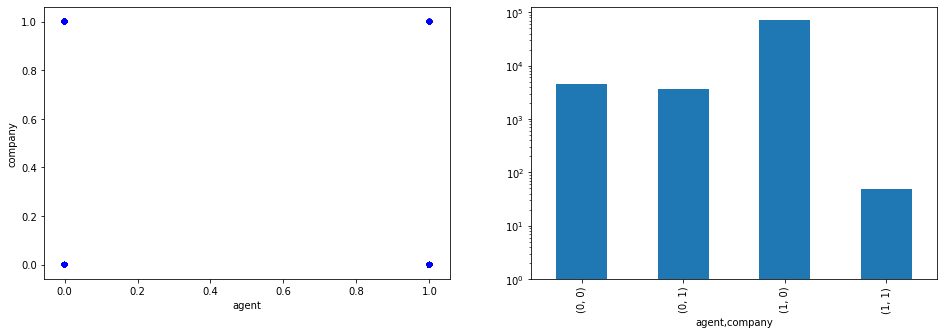

In [97]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
hbd.plot.scatter("agent","company", c=diagnosis_colors, ax=ax1);
hbd.groupby(['agent','company']).size().plot.bar(ax=ax2, log=True)

- Visualizzo la coppia (`is_repeated_guest`, `previous_bookings_not_canceled`)

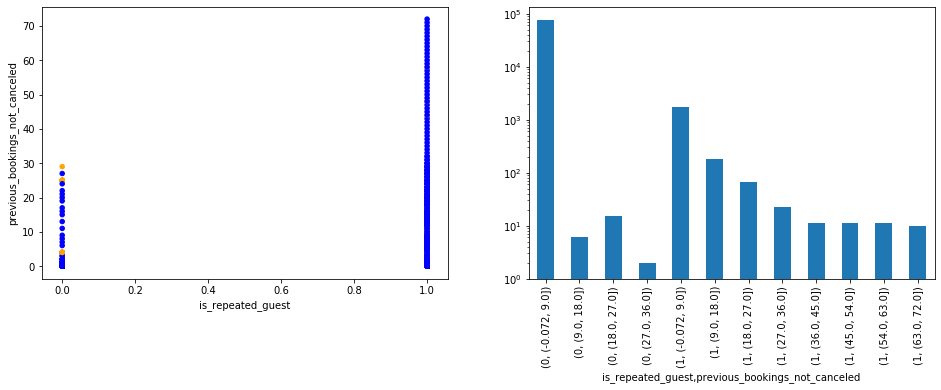

In [208]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
hbd.plot.scatter("is_repeated_guest","previous_bookings_not_canceled", c=diagnosis_colors, ax=ax1);
hbd.groupby(['is_repeated_guest', pd.cut(hbd.previous_bookings_not_canceled, 8)]).size().plot.bar(ax=ax2, log=True)

- Visualizzo la coppia (`is_repeated_guest`, `company`)

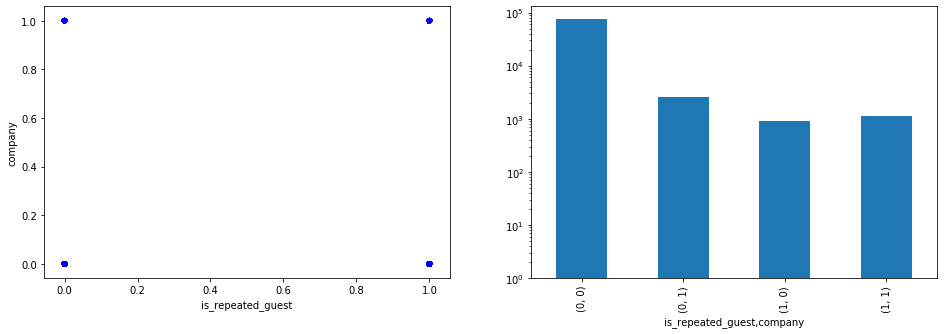

In [99]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
hbd.plot.scatter("is_repeated_guest","company", c=diagnosis_colors, ax=ax1);
hbd.groupby(['is_repeated_guest', 'company']).size().plot.bar(ax=ax2, log=True)

- Visualizzo la coppia (`previous_bookings_not_canceled`, `previous_cancellations`)

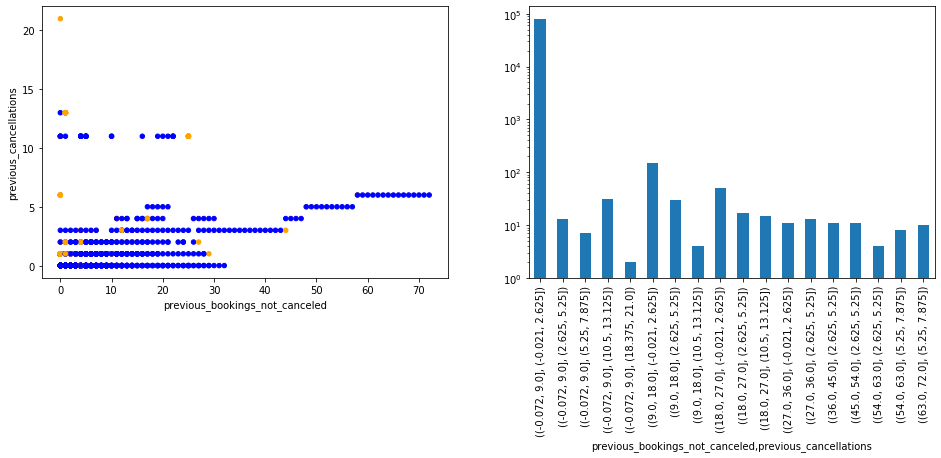

In [212]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
hbd.plot.scatter("previous_bookings_not_canceled","previous_cancellations", c=diagnosis_colors, ax=ax1);
hbd.groupby([pd.cut(hbd.previous_bookings_not_canceled, 8), pd.cut(hbd.previous_cancellations, 8)]).size().plot.bar(ax=ax2, log=True)

- Analiziamo ora una serie di variabili che possono risultare essere interessanti per il nostro studio

#### Variabile `is_canceled`

- Stampiamo il numero di valori `0` e `1` della variabile `is_canceled`, e rappresentiamo la distribuzione di tali valori in un diagramma a torta

In [42]:
hbd["is_canceled"].value_counts()

0    46226
1    33076
Name: is_canceled, dtype: int64

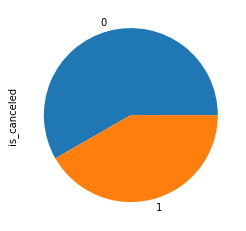

In [43]:
hbd["is_canceled"].value_counts().plot.pie();

- La suddivisione delle istanze nelle classi è abbastanza bilanciata, non siamo dunque soggetti ai problemi che un forte sblinciamento comporterebbe.

#### Variabile `lead_time`

Text(0, 0.5, 'Cancelations [%]')

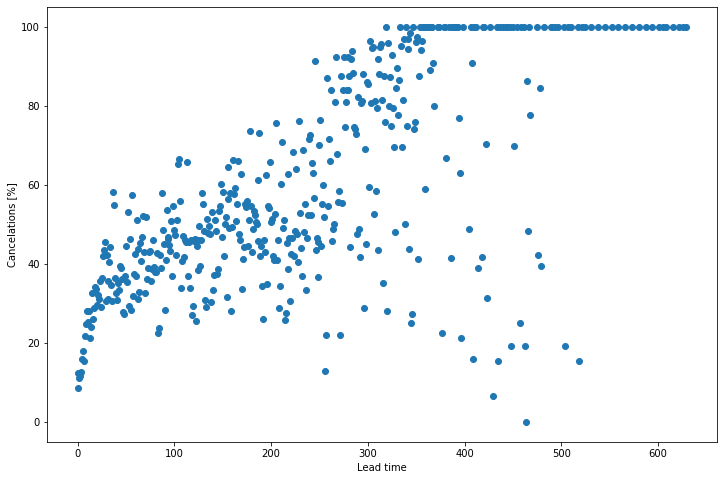

In [115]:
plt.figure(figsize=(12, 8))
lead_time_describe = hbd.groupby("lead_time")["is_canceled"].describe()
plt.scatter(lead_time_describe.index, lead_time_describe["mean"] * 100)
plt.xlabel("Lead time")
plt.ylabel("Cancelations [%]")

- Le prenotazione fatte qualche giorno prima dell'arrivo in struttura sono raramente cancellate, a differenza di prenotazioni fatte a distanza di mese (se non di anni)

- Visualizziamo due grafici a barre di `lead_time`, per avere più chiaro il suo comportamento
    - Nel primo in ogni intervallo è mostrato il numero di prenotazioni
    - Nel secondo in ogni intervallo è mostrato il numero di cancellazioni

[Text(0, 0.5, 'Numero di cancellazioni'), Text(0.5, 0, 'Intervallo lead_time')]

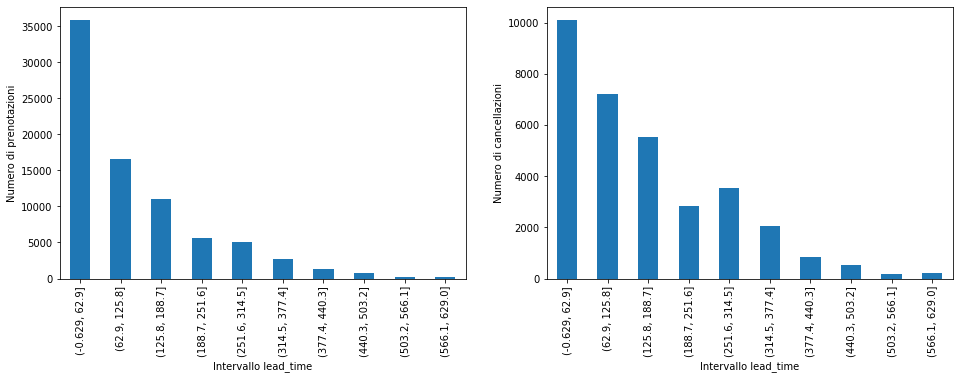

In [262]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
pd.cut(hbd["lead_time"], 10).value_counts().plot.bar(ax=ax1)
hbd.groupby(pd.cut(hbd["lead_time"], 10)).sum()["is_canceled"].plot.bar(ax=ax2)
ax1.set(xlabel="Intervallo lead_time", ylabel="Numero di prenotazioni")
ax2.set(xlabel="Intervallo lead_time", ylabel="Numero di cancellazioni")

- Le prenotazioni più frequenti sono quelle a breve termine, ovvero senza lunghi periodi fra il momento della prenotazione e l'arrivo in hotel
- Medesima cosa vale per le cancellazioni, anche essere maggiore nelle prenotazioni a breve termine


#### Variabile `deposit_type`

- Con il medesimo approccio di `lead_time` visualizziamo due grafici a barre
    - Nel primo in ogni intervallo è mostrato il numero di prenotazioni
    - Nel secondo in ogni intervallo è mostrato il numero di cancellazioni

[Text(0, 0.5, 'Numero di cancellazioni')]

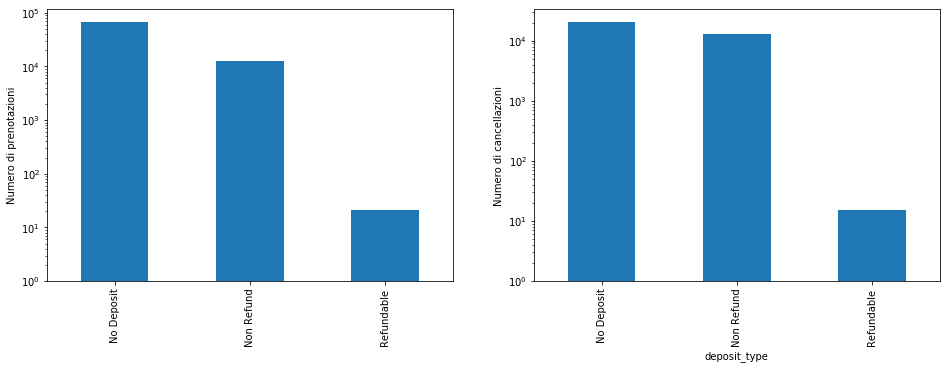

In [263]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
hbd["deposit_type"].value_counts().plot.bar(log=True, ax=ax1)
hbd.groupby("deposit_type").sum()["is_canceled"].plot.bar(log=True, ax=ax2)
ax1.set(ylabel="Numero di prenotazioni")
ax2.set(ylabel="Numero di cancellazioni")

- Visualizziamo un ultimo grafico a barre di `deposit_type`, in cui in venga visualizzato per ciascuna possibilo valore il tasso di cancellazione 
    - Il tasso di cancellazione è inteso come il il numero di cancellazioni diviso il numero di prenotazioni

Text(0, 0.5, 'Tasso di cancellazione')

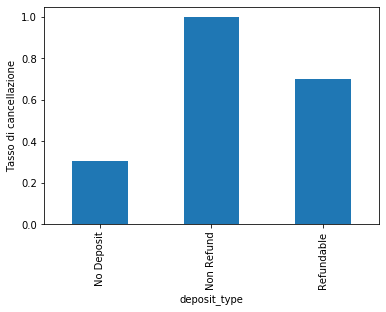

In [264]:
(hbd.groupby("deposit_type").sum()["is_canceled"] / hbd["deposit_type"].value_counts()).plot.bar()
plt.ylabel("Tasso di cancellazione")

- Visualizziamo i valori esatti

In [265]:
(hbd.groupby("deposit_type").sum()["is_canceled"] / hbd["deposit_type"].value_counts())

deposit_type
No Deposit    0.304570
Non Refund    0.998133
Refundable    0.700000
dtype: float64

- Il grafico evidenzia che per il valore 'Non Refund' la percentuale di cancellazioni è pari quasi al 100%

- E' un po controintuitivo, per cui verifichiamo le istanze per averne la certezza

In [266]:
hbd[hbd["deposit_type"] == "Non Refund"]["is_canceled"].value_counts()

1    12830
0       24
Name: is_canceled, dtype: int64

- Effettivamente pare che quasi tutte le prenotazioni _Non Refund_ siano state cancellate

#### Variabile `total_of_special_requests`

Text(0, 0.5, 'Cancelations [%]')

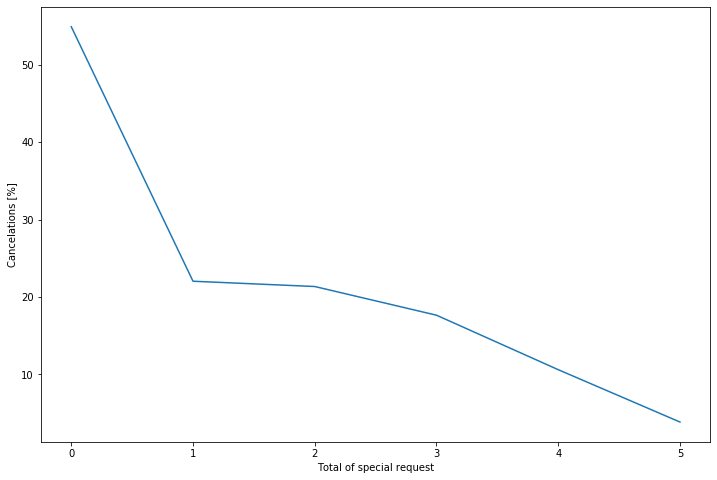

In [308]:
plt.figure(figsize=(12, 8))
lead_time_describe = hbd.groupby("total_of_special_requests")["is_canceled"].describe()
plt.plot(lead_time_describe.index, lead_time_describe["mean"] * 100)
plt.xlabel("Total of special request")
plt.ylabel("Cancelations [%]")

- Possiamo notare come all'aumentare del numero di richieste speciali la percentuale di cancellazioni diminuisca rapidamente

#### Variabile `required_car_parking_spaces`

Text(0, 0.5, 'Cancelations [%]')

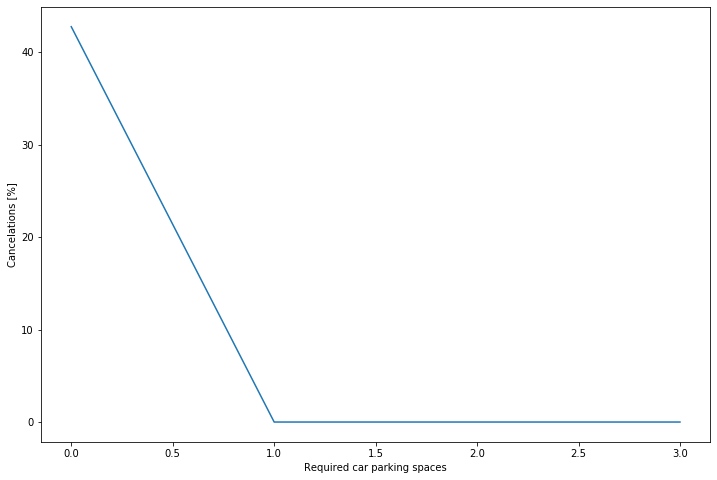

In [334]:
plt.figure(figsize=(12, 8))
lead_time_describe = hbd.groupby("required_car_parking_spaces")["is_canceled"].describe()
plt.plot(lead_time_describe.index, lead_time_describe["mean"] * 100)
plt.xlabel("Required car parking spaces")
plt.ylabel("Cancelations [%]")

In [315]:
hbd.groupby("is_canceled")["required_car_parking_spaces"].sum()

is_canceled
0    1933
1       0
Name: required_car_parking_spaces, dtype: int64

- Possiamo notare come non sia mai stata registrata nella nessuna cancellazioni di una prenotazione in cui fosse presente la richiesta di almeno un posto macchina

#### Variabile `previous_cancellations`

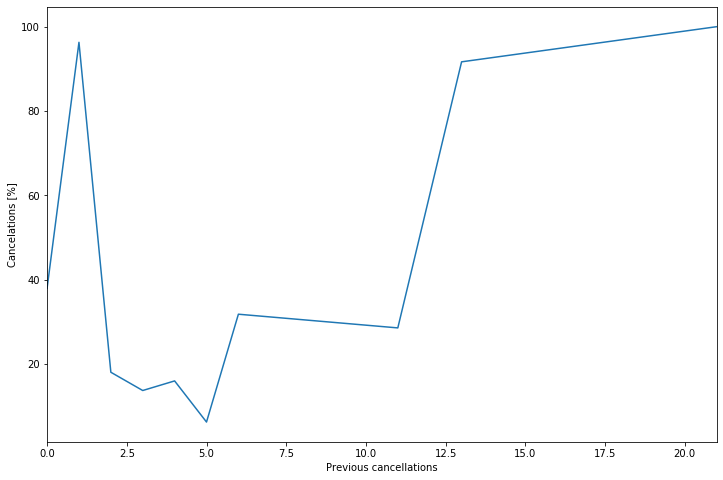

In [337]:
plt.figure(figsize=(12, 8))
plt.xlabel("Previous cancellations")
plt.ylabel("Cancelations [%]")
((hbd.groupby("previous_cancellations").sum()["is_canceled"] / hbd["previous_cancellations"].value_counts())*100).plot()

- Eccetto inizialmente, all'aumentare delle prenotazioni pregresse cancellate aumenta anche la probabilità di cancellazioni

#### Variabile `booking_changes`

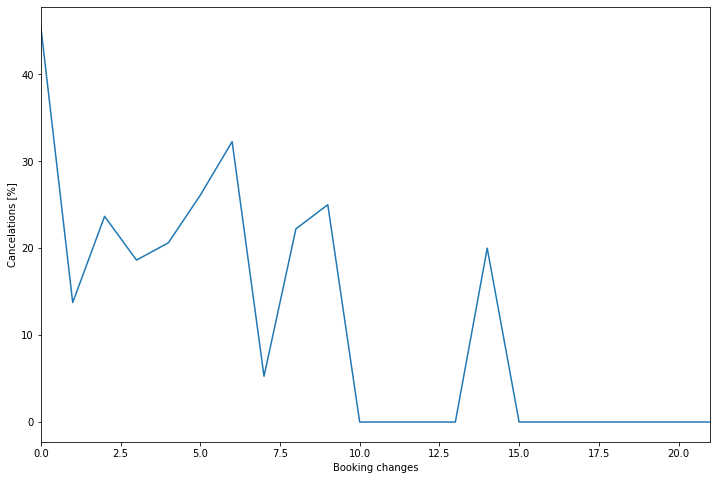

In [335]:
plt.figure(figsize=(12, 8))
plt.xlabel("Booking changes")
plt.ylabel("Cancelations [%]")
((hbd.groupby("booking_changes").sum()["is_canceled"] / hbd["booking_changes"].value_counts())*100).plot()

- All'aumentare delle richieste di cambiamento sulla prenotazione la percentuale di cancellazioni tende a crescere

#### Variabili `stays_in_weekend_nights`, `stays_in_week_nights`

- Mostriamo due grafici a barre in cui visualizziamo per ogni valore delle variabili `stays_in_weekend_nights` e `stays_in_week_nights`, ovvero il numero di notti prenotate rispettivamente durante il finesettimana e non durante il finesettimana, il tasso di cancellazione

Text(0, 0.5, 'Tasso di cancellazione')

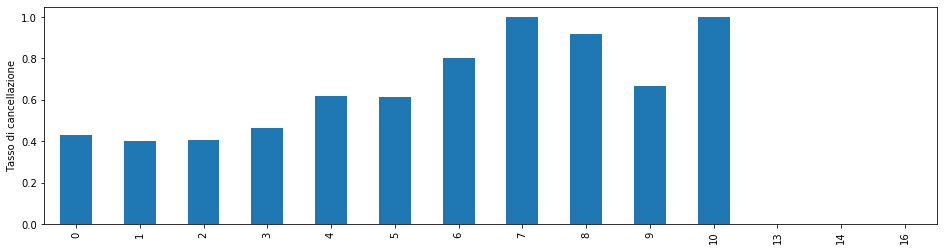

In [52]:
(hbd.groupby("stays_in_weekend_nights").sum()["is_canceled"] / hbd["stays_in_weekend_nights"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Tasso di cancellazione")

Text(0, 0.5, 'Tasso di cancellazione')

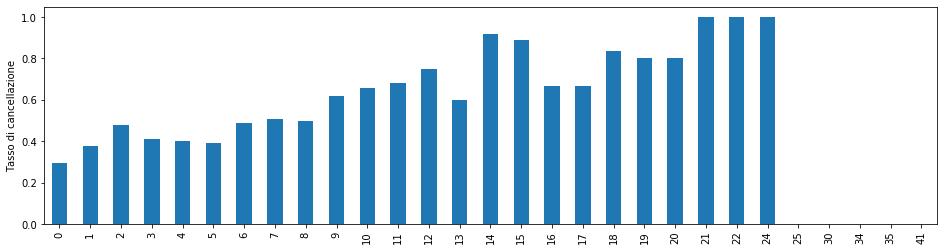

In [53]:
(hbd.groupby("stays_in_week_nights").sum()["is_canceled"] / hbd["stays_in_week_nights"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Tasso di cancellazione")

- In entrambi i casi possiamo notare un tasso di cancellazione che cresce in modo considerevole all'aumentare del numero di notti prenotate

#### Variabili `arrival_date_day`, `arrival_date_month`, `arrival_date_week_number` 

- Mostriamo un grafico a barre per le variabili `arrival_date_day`, `arrival_date_month`, `arrival_date_week_number` in cui visualizziamo per possibile valore di ciascuna il tasso di cancellazione

Text(0, 0.5, 'Tasso di cancellazione')

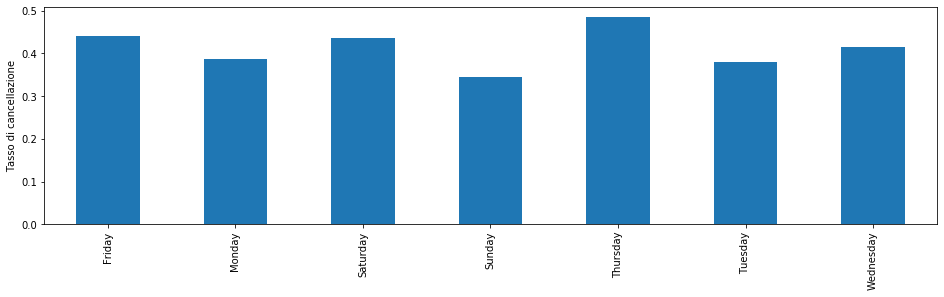

In [294]:
(hbd.groupby("arrival_date_day").sum()["is_canceled"] / hbd["arrival_date_day"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Tasso di cancellazione")

Text(0, 0.5, 'Tasso di cancellazione')

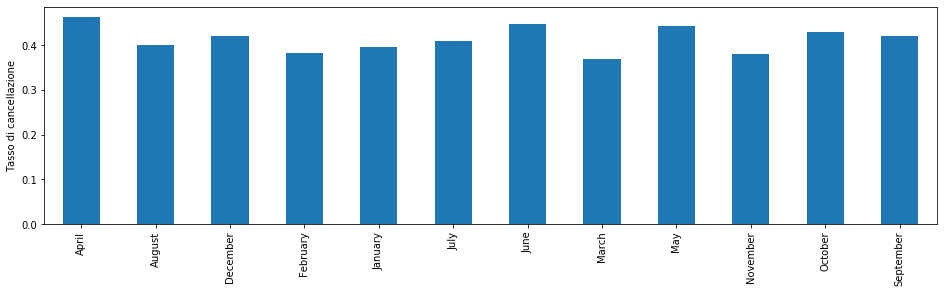

In [295]:
(hbd.groupby("arrival_date_month").sum()["is_canceled"] / hbd["arrival_date_month"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Tasso di cancellazione")

Text(0, 0.5, 'Tasso di cancellazione')

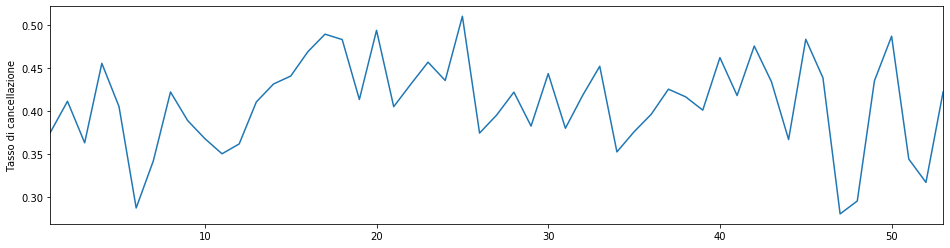

In [301]:
(hbd.groupby("arrival_date_week_number").sum()["is_canceled"] / hbd["arrival_date_week_number"].value_counts()).plot(figsize=(16,4))
plt.ylabel("Tasso di cancellazione")

#### Qualche altra variabile ...

- Mostriamo infine rapidamente il tasso di cancellazione di qualche altra variabili, al fine di comprendere il dominio in cui lavoriamo correttamente

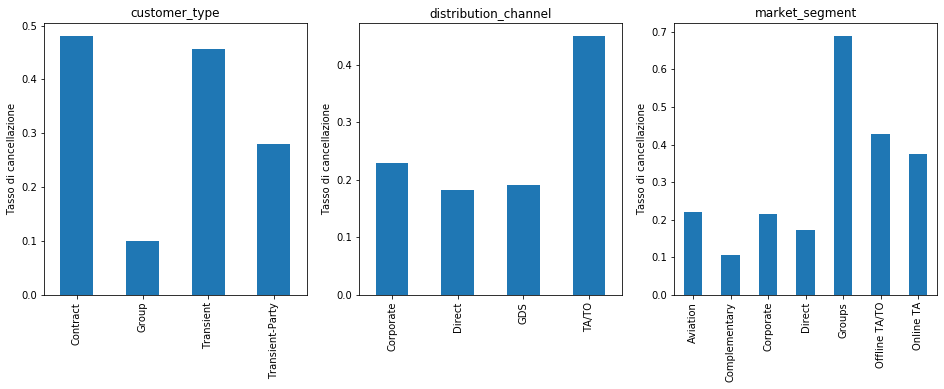

In [279]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set(ylabel="Tasso di cancellazione")
ax2.set(ylabel="Tasso di cancellazione")
ax3.set(ylabel="Tasso di cancellazione")
ax1.set_title('customer_type')
ax2.set_title('distribution_channel')
ax3.set_title('market_segment')
(hbd.groupby("customer_type").sum()["is_canceled"] / hbd["customer_type"].value_counts()).plot.bar(ax=ax1)
(hbd.groupby("distribution_channel").sum()["is_canceled"] / hbd["distribution_channel"].value_counts()).plot.bar(ax=ax2)
(hbd.groupby("market_segment").sum()["is_canceled"] / hbd["market_segment"].value_counts()).plot.bar(ax=ax3)

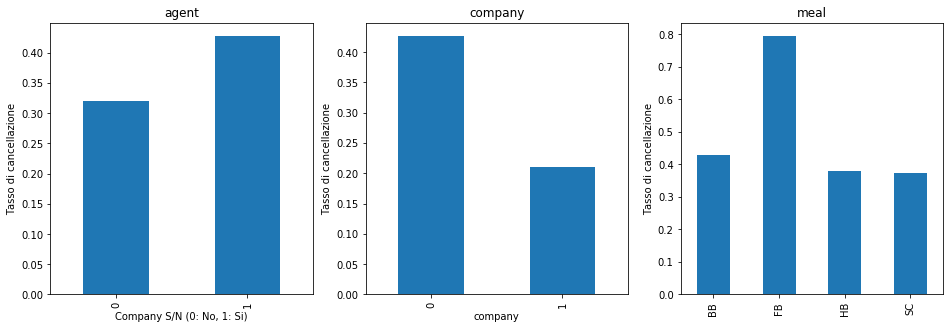

In [326]:
fig = plt.figure(figsize=(16, 5))
ax4 = fig.add_subplot(131)
ax5 = fig.add_subplot(132)
ax6 = fig.add_subplot(133)
ax4.set(ylabel="Tasso di cancellazione")
ax5.set(ylabel="Tasso di cancellazione")
ax6.set(ylabel="Tasso di cancellazione")
ax4.set(xlabel="Agent S/N (0: No, 1: Si")
ax4.set(xlabel="Company S/N (0: No, 1: Si)")
ax4.set_title('agent')
ax5.set_title('company')
ax6.set_title('meal')
(hbd.groupby("agent").sum()["is_canceled"] / hbd["agent"].value_counts()).plot.bar(ax=ax4)
(hbd.groupby("company").sum()["is_canceled"] / hbd["company"].value_counts()).plot.bar(ax=ax5)
(hbd.groupby("meal").sum()["is_canceled"] / hbd["meal"].value_counts()).plot.bar(ax=ax6)

## Classificazione lineare

- Convertiamo, per maggiore chiarezza, i valori della variabile `is_canceled` (ovvero 0 e 1) in `N` e `Y`:
    - `0` diventa `N`, ovvero non cancellata
    - `1` diventa `Y`, ovvero cancellata

In [118]:
hbd["is_canceled"] = hbd["is_canceled"].map(lambda value: "N" if value is 0 else "Y")
hbd["is_canceled"].unique()

array(['N', 'Y'], dtype=object)

- Impostiamo come variabile da predire la classe `is_canceled` e come variabili predittive tutte le altre

In [119]:
y = hbd["is_canceled"]
X = hbd.drop(columns="is_canceled")

- Molte variabili sono categoriche, è quindi necessario applicare la binarizzazione delle feature, ovvero convertire ciascuna di esse in più variabili binarie. 

- Le variabili da convertire sono:

In [120]:
X.dtypes[hbd.dtypes == np.object]

arrival_date_day        object
arrival_date_month      object
meal                    object
country                 object
market_segment          object
distribution_channel    object
reserved_room_type      object
deposit_type            object
customer_type           object
dtype: object

- La conversione viene eseguita, in modo molto basilare, dal comando `get_dummies`
    - NB: non sono previste variabili per tutti quei valori non presenti nel dataset

In [121]:
X = pd.get_dummies(X)

In [122]:
X.shape[1]

232

In [123]:
X.columns.tolist()

['lead_time',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'arrival_date_day_Friday',
 'arrival_date_day_Monday',
 'arrival_date_day_Saturday',
 'arrival_date_day_Sunday',
 'arrival_date_day_Thursday',
 'arrival_date_day_Tuesday',
 'arrival_date_day_Wednesday',
 'arrival_date_month_April',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'country_ABW',
 'country_AGO',
 '

- Suddividiamo i dati in un training set e in un validation set con la funzione `train_test_split` con proporzione 66-33

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=1/3, 
    random_state=42
)

- Definiamo un modello di regressione logistica più semplice possibile, configurandone l'implementazione e il seed per la casualità
  - gli altri parametri sono lasciati ai valori di default, ad es. la regolarizzazione applicata è L2 con C=1

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = LogisticRegression(solver="saga", random_state=42)  

- Addestriamo il modello sui dati

In [126]:
model.fit(X_train, y_train)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

- Mostriamo le classi previste dal modello

In [127]:
model.classes_

array(['N', 'Y'], dtype=object)

- NB: Quando effettuiamo una predizione di probabilità otteniamo due valori ([a, b])
    - Il primo valore (a) si riferisce alla probabilità di ottenere la classe `N`
    - Il secondo valore (b) si riferisce alla probabilità di ottenere la classe `Y`

In [128]:
model.predict_proba(X_val[:3])

array([[0.30420672, 0.69579328],
       [0.10950688, 0.89049312],
       [0.37674281, 0.62325719]])

In [129]:
model.predict(X_val[:3])

array(['Y', 'Y', 'Y'], dtype=object)

- Definiamo una funzione per ottenere le informazioni più interessanti che ci possono essere utili per valutare il modello

- Oltre all'accuratezza come percentuale di classificazioni corrette, esistono altri modi per valutare l'accuratezza di un classificatore
    - Precision e recall sono particolarmente utili in caso di sbilanciamento tra le classi, per cui l'accuratezza può non essere un indicatore affidabile

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def print_model_informations(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print("Accuracy =", model.score(X_val, y_val))
    print("\nPrecision (Y) =", precision_score(y_val,y_pred, pos_label="Y"))
    print("Precision (N) =", precision_score(y_val,y_pred, pos_label="N"))
    print("Precision =", precision_score(y_val,y_pred, average="macro"))
    print("\nRecall (Y) =", recall_score(y_val,y_pred, pos_label="Y"))
    print("Recall (N) =", recall_score(y_val,y_pred, pos_label="N"))
    print("Recall =", recall_score(y_val,y_pred, average="macro"))
    print("\nF1 Score (Y) =", f1_score(y_val,y_pred, pos_label="Y"))
    print("F1 Score (N) =", f1_score(y_val,y_pred, pos_label="N"))
    print("F1 Score =", f1_score(y_val,y_pred, average="macro"))
    print("\nMatrice di confusione:")
    cm = confusion_matrix(y_val, y_pred)
    print(pd.DataFrame(cm, index=model.classes_, columns=model.classes_))

- Calcoliamo le misure del nostro modello 

In [131]:
print_model_informations(model, X_val, y_val)

Accuracy = 0.796247257320118

Precision (Y) = 0.8480108387732479
Precision (N) = 0.7733005733005733
Precision = 0.8106557060369106

Recall (Y) = 0.6238108181571079
Recall (N) = 0.9198545171137235
Recall = 0.7718326676354157

F1 Score (Y) = 0.7188348298183337
F1 Score (N) = 0.8402349311817751
F1 Score = 0.7795348805000544

Matrice di confusione:
       N     Y
N  14163  1234
Y   4152  6885


- Per avere una valutazione più completa del modello ottento, possiamo metterlo a confronto con quello che accadrebbe prendendo decisioni casuali
    - Generiamo un serie di decisioni casuali (`Y` o `N`)

In [132]:
import random
randoms = pd.Series(np.random.choice(["Y", "N"], size=(y_val.index.shape[0],)), index = y_val.index) 

- Calcoliamo l'accuratezza di questo modello randomico

In [133]:
(y_val == randoms).mean()

0.5051827192252403

- Abbiamo ottenuto un modello che ci consente di intraprendere decisioni più accurate di come le faremmo casualmente

### Verifichiamo se la variabile deposit_type ha un grosso impatto sulla valutazione
  

- Rimuoviamo la variabile `deposit_type` da una copia dei dataset X_train e X_val appena utilizzati

In [353]:
X_train_no_deposit = X_train.copy()
X_val_no_deposit = X_val.copy()
X_train_no_deposit.drop(columns=['deposit_type_No Deposit', 'deposit_type_Non Refund','deposit_type_Refundable'], inplace=True)
X_val_no_deposit.drop(columns=['deposit_type_No Deposit', 'deposit_type_Non Refund','deposit_type_Refundable'], inplace=True)

- Addestriamo un modello con la medesima configurazione appena utilizzata

In [355]:
model = LogisticRegression(solver="saga", random_state=42)  
model.fit(X_train_no_deposit, y_train)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

- Verifichiamone l'accuratezza

In [356]:
print_model_informations(model, X_val_no_deposit, y_val)

Accuracy = 0.786562760081713

Precision (Y) = 0.7882252377390747
Precision (N) = 0.7856515373352855
Precision = 0.78693838753718

Recall (Y) = 0.66838814895352
Recall (N) = 0.8712736247320907
Recall = 0.7698308868428053

F1 Score (Y) = 0.7233771327711316
F1 Score (N) = 0.826250307957625
F1 Score = 0.7748137203643783

Matrice di confusione:
       N     Y
N  13415  1982
Y   3660  7377


- Sembra peggiorare ma, quello che più importa, è che ora sappiamo che il modello non peggiore drasticamente senza questa variabile

## Regolarizzazione

- Nella regressione logistica possiamo applicare le teniche di regolarizzazione
    - In particolare vogliamo applicare la regolarizzazione L1 che permette di azzerare i pesi delle variabili meno significative
    - Applichiamo una forte regolarizzazione al fine di annullare più valiabili possibili

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = LogisticRegression(solver="saga", random_state=42, penalty="l1", C=100)  
model.fit(X_train, y_train)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

- Andiamo a visualizzare i coefficienti più grandi in valore assoluto

In [148]:
pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False).head(10)

country_PRT                    0.777396
deposit_type_Non Refund        0.732781
previous_cancellations         0.368407
customer_type_Transient        0.307675
market_segment_Online TA       0.231952
market_segment_Groups          0.163888
distribution_channel_TA/TO     0.124428
arrival_date_month_December    0.089841
stays_in_week_nights           0.083946
meal_SC                        0.058953
dtype: float64

In [149]:
pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False).tail(10)

required_car_parking_spaces     -0.173216
market_segment_Direct           -0.206676
distribution_channel_Direct     -0.222695
market_segment_Offline TA/TO    -0.261850
country_FRA                     -0.277665
country_DEU                     -0.328674
booking_changes                 -0.393963
customer_type_Transient-Party   -0.515777
total_of_special_requests       -0.700450
deposit_type_No Deposit         -0.927112
dtype: float64

- Visualizziamo anche l'intercetta

In [177]:
model.intercept_

array([-0.19381644])

- La gran parte dei coefficienti mostrati sono di variabili binarie dunque, nonostante il loro valore sia alto, possono incidere sull'esito al più di una unità in valore assoluto


## Cross-validation su classificazione

- Quello che vogliamo fare ora è applicare la GridSearch per trovare gli iperparametri migliori
 
- Poichè il dataset è molto ampio e la variabili sono molte, la ricerca degli iperparametri ottimali risulta essere molto dispendiosa.

- Riduciamo la dimensione del dataset in termini di variabili 
    - Ottenuti i pesi della regolarizzazione L1, poniamo una soglia del +- 0.1 affinchè un coefficiente possa essere tenuto in considerazione. Se inferiore rimuoviamo quella variabile dal dataframe. 

- Realizzo una copia dei dataset di training ed validation a cui andrò a rimuovere parte delle variabili

In [118]:
X_train_v2 = X_train.copy()
y_train_v2 = y_train.copy()
X_val_v2 = X_val.copy()
y_val_v2 = y_val.copy()

In [119]:
X_train_v2.shape, X_val_v2.shape

((52868, 232), (26434, 232))

- Rimuoviamo ora parte delle variabili, quelle meno significative, sia dal dataset di training che di validation

- Definiamo un vettore `coeff` contenente tutte le variabili da eliminare

In [120]:
coeff = pd.Series(model.coef_[0], index=X.columns)
coeff = coeff[(coeff < 0.3) & (coeff > -0.3)]

- Viene quindi utilizzato `coeff` per rimuovere le variabili dal training set e dal validation set

In [121]:
X_train_v2.drop(axis=1,columns=coeff.index, inplace=True)
X_val_v2.drop(axis=1,columns=coeff.index, inplace=True)
print("Ho scartato", coeff.shape[0], "variabili")

Ho scartato 225 variabili


In [122]:
X_train_v2.shape, X_val_v2.shape

((52868, 7), (26434, 7))

- Addestriamo un nuovo modello con la prima configurazione adottata su questo nuovo training set

In [123]:
model_v2 = LogisticRegression(solver="saga", random_state=42)  
model_v2.fit(X_train_v2, y_train_v2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [124]:
print_model_informations(model_v2, X_val_v2, y_val_v2)

Accuracy = 0.7384429144283877

Precision (Y) = 0.8367913739585036
Precision (N) = 0.7088071678235612
Precision = 0.7727992708910324

Recall (Y) = 0.464075382803298
Recall (N) = 0.9351172306293434
Recall = 0.6995963067163207

F1 Score (Y) = 0.5970392819675954
F1 Score (N) = 0.8063847661719405
F1 Score = 0.701712024069768

Matrice di confusione:
       N     Y
N  14398   999
Y   5915  5122


- Confrontiamolo con la stessa configurazione addestrata però sul dataset completo di tutte le variabili (già precedentemente addestrato)

In [125]:
print_model_informations(model, X_val, y_val)

Accuracy = 0.7922372701823409

Precision (Y) = 0.8526007885031158
Precision (N) = 0.7666792310591782
Precision = 0.809640009781147

Recall (Y) = 0.607411434266558
Recall (N) = 0.9247255958953042
Recall = 0.7660685150809311

F1 Score (Y) = 0.7094179894179895
F1 Score (N) = 0.8383184173339612
F1 Score = 0.7738682033759754

Matrice di confusione:
       N     Y
N  14238  1159
Y   4333  6704


- Definiamo uno `StatifiedKFold` per effettuare la cross-validation
    - Dovendo addestrare un modello a riconoscere delle classi, è opportuno che le proporzioni di ciascuna classe nei fold siano uguali
    - `StratifiedKFold` è una variante di `KFold` che garantisce uguale distribuzione delle classi tra un fold e l'altro

In [126]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
skf = StratifiedKFold(3, shuffle=True, random_state=42)

In [127]:
for train, val in skf.split(X_train_v2, y_train_v2):
    print(y_train.iloc[val].value_counts())

N    10277
Y     7347
Name: is_canceled, dtype: int64
N    10276
Y     7346
Name: is_canceled, dtype: int64
N    10276
Y     7346
Name: is_canceled, dtype: int64


- Definizamo una "griglia" con liste di valore possibili per gli iperparametri di un modello, al fine di testare tutte le combinazioni possibili mediante la grid search

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

mod = Pipeline([
    ("scaler", None),
    ("poly", None),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
        "poly": [None],
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
        "poly": [PolynomialFeatures()],
        "poly__degree": [2,3,4]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-3, 3, 7),
        "poly": [None]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-3, 3, 7),
        "poly": [PolynomialFeatures()],
        "poly__degree": [2,3,4]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-3, 3, 7),
        "lr__l1_ratio": [0.2, 0.5, 0.7],
        "poly": [None]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-3, 3, 7),
        "lr__l1_ratio": [0.2, 0.5, 0.7],
        "poly": [PolynomialFeatures()],
        "poly__degree": [2,3,4]
    }
]

- Poniamo un filtro in modo che i warning del training non vengano mostrati

In [129]:
import warnings
warnings.filterwarnings("ignore") 

- Definiamo la grid search, specificando il modello, la lista di griglie e lo splitter per la cross-validation (usiamo lo `StratifiedKFold` creato sopra)

In [130]:
gs = GridSearchCV(mod, grid, cv=skf)

- Effettuiamo quindi la ricerca sui dati 

In [ ]:
%time gs.fit(X_train_v2, y_train_v2)

- Possiamo verificare la migliore combinazione di iperparametri
    -  metrica di riferimento di default è l'accuratezza, cioè la percentuale di classificazioni corrette

In [1571]:
gs.best_params_

{'lr__C': 0.01,
 'lr__l1_ratio': 0.2,
 'lr__penalty': 'elasticnet',
 'scaler': None}

- E vedere tutti i dettagli, ad es. selezionando le 5 parametrizzazioni con accuratezza migliore

In [1572]:
result = pd.DataFrame(gs.cv_results_)
result.sort_values(by="rank_test_score", inplace=True)
result.reset_index(inplace=True, drop=True)
result.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.714678,0.022306,0.034656,0.000477,elasticnet,None,0.01,0.2,"{'lr__C': 0.01, 'lr__l1_ratio': 0.2, 'lr__pena...",0.786882,0.790205,0.788957,0.788681,0.001371,1
1,1.252669,0.006544,0.034663,0.000468,l2,None,0.01,NaN,"{'lr__C': 0.01, 'lr__penalty': 'l2', 'scaler':...",0.786428,0.790262,0.789184,0.788624,0.001615,2
2,1.640007,0.023419,0.034661,0.000466,elasticnet,None,0.1,0.2,"{'lr__C': 0.1, 'lr__l1_ratio': 0.2, 'lr__penal...",0.786995,0.789297,0.789127,0.788473,0.001048,3
3,1.688017,0.017202,0.034317,0.000475,elasticnet,None,0.1,0.7,"{'lr__C': 0.1, 'lr__l1_ratio': 0.7, 'lr__penal...",0.786938,0.789354,0.789127,0.788473,0.001089,3
4,1.253333,0.005186,0.034333,0.000472,l2,None,0.1,NaN,"{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",0.786995,0.789297,0.789127,0.788473,0.001048,3


- Andiamo a visualizzare le misure del miglior modello ottenuto

In [1573]:
print_model_informations(gs, X_val_v2, y_val_v2)

Accuracy = 0.791442838768253

Precision (Y) = 0.8152248345126684
Precision (N) = 0.7796514259846085
Precision = 0.7974381302486384

Recall (Y) = 0.6471867355259582
Recall (N) = 0.8948496460349419
Recall = 0.7710181907804501

F1 Score (Y) = 0.7215515935148241
F1 Score (N) = 0.833287973630893
F1 Score = 0.7774197835728586

Matrice di confusione:
       N     Y
N  13778  1619
Y   3894  7143


- Possiamo notare un valore non eccelso per quanto riguarda `Recall (Y)`, ovvero la percentuale di istanze cancellate che sono state classificate come cancellate. 
    - La restante parte, in questo caso abbastanza cospicua, definisce quelle istanze che sono cancellate ma sono state classificate come non cancellate.

In [1563]:
from sklearn.preprocessing import PolynomialFeatures
mod = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures()),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])

In [1565]:
mod.fit(X_train_v2, y_train_v2)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [1566]:
mod.score(X_val_v2, y_val_v2)

0.7919346296436408

## Valutazione dei modelli di classificazione

- Andiamo a prendere i parametri dei tre modelli testati che hanno ottenuto i valori _rank_test_score_ più alti

- Primo in classifica

In [1508]:
result.loc[0, 'params']

{'lr__C': 0.01,
 'lr__l1_ratio': 0.2,
 'lr__penalty': 'elasticnet',
 'scaler': None}

- Secondo in classifica

In [1509]:
result.loc[1, 'params']

{'lr__C': 0.01, 'lr__penalty': 'l2', 'scaler': None}

- Terzo in classifica

In [1510]:
result.loc[2, 'params']

{'lr__C': 0.1,
 'lr__l1_ratio': 0.2,
 'lr__penalty': 'elasticnet',
 'scaler': None}

- Dai parametri mostrati genero tre modelli, i tre modelli ipoteticamente migliori

In [1511]:
import copy
model_1 = copy.deepcopy(gs.best_estimator_.set_params(**result.loc[0, 'params']))
model_2 = copy.deepcopy(gs.best_estimator_.set_params(**result.loc[1, 'params']))
model_3 = copy.deepcopy(gs.best_estimator_.set_params(**result.loc[2, 'params']))

In [1512]:
model_1.get_params(deep=False)

{'memory': None,
 'steps': [('scaler', None),
  ('lr',
   LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=0.2, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='elasticnet',
                      random_state=42, solver='saga', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False}

In [1513]:
model_2.get_params(deep=False)

{'memory': None,
 'steps': [('scaler', None),
  ('lr',
   LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=0.2, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='l2',
                      random_state=42, solver='saga', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False}

In [1514]:
model_3.get_params(deep=False)

{'memory': None,
 'steps': [('scaler', None),
  ('lr',
   LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=0.2, max_iter=100,
                      multi_class='warn', n_jobs=None, penalty='elasticnet',
                      random_state=42, solver='saga', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False}

### Intervallo di confidenza sui modelli

In [1515]:
from scipy.stats import norm

- Definiamo una funzione `conf_interval` che calcoli gli estremi dell'intervallo di confidenza e restituisca una tupla con i due estremi, dove:
  - $a$ è l'accuratezza del modello misurata sul validation set
  - N è il numero di osservazioni nel validation set
  - Z è il valore tale per cui l'area sottesa dalla densità di probabilità $\varphi(x)$ della distribuzione normale standard tra -Z e Z sia il livello di confidenza 1-𝛼
  
- Poichè a noi interessa valutare i modelli con una condifidenza del 95%, possiamo ricavare dalle apposite tabelle di valori che, per 1-𝛼 = 0.95 (𝛼=0.05), Z = 1.96

In [1516]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

- Definisco ora una funzione `model_conf_interval` in modo che:
  - prenda in input un modello addestrato `model`, un validation set `X, y` e un livello di confidenza `level` (default 0.95)
  - restituisca l'intervallo di confidenza dell'accuratezza del modello, servendosi della funzione `conf_interval` sopra


In [1517]:
def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
    N = X.shape[0]
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

- Usiamo la funzione `model_conf_interval` per calcolare l'intervallo di confidenza al 95% dell'accuratezza dei tre modelli ottenuti stimata sul validation set  

In [1518]:
model_conf_interval(model_1, X_val_v2, y_val_v2)

(0.7865030005257252, 0.7962979828298691)

In [1519]:
model_conf_interval(model_2, X_val_v2, y_val_v2)

(0.7865030005257252, 0.7962979828298691)

In [1520]:
model_conf_interval(model_3, X_val_v2, y_val_v2)

(0.7865030005257252, 0.7962979828298691)

### Confronto tra modelli

- Dati due modelli diversi, vogliamo poter valutare se l'accuratezza  𝑎1  misurata su uno sia significativamente migliore della  𝑎2  misurata sull'altro.

- Implementiamo la funzione `diff_interval` in modo che
  - prenda in input le accuratezze `a1` e `a2`, i numeri di osservazioni `N1` e `N2` e il coefficiente `Z`
  - calcoli l'intervallo di confidenza della differenza tra due modelli secondo la formula sopra

In [1521]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

- Implementiamo la funzione `model_diff_interval` in modo che
  - prenda in input due modelli `m1, m2`, un validation set `X, y` e un livello di confidenza `level` (default 0.95)
  - restituisca l'intervallo di confidenza della differenza di accuratezza tra i due modelli, valutati entrambi sul validation set dato

In [1522]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

- Utilizziamo `model_diff_interval` per calcolare l'intervallo al 95\% della differenza di accurateza sul validation set tra i tre modelli ottenuti

In [1523]:
model_diff_interval(model_1, model_2, X_val_v2, y_val_v2)

(-0.006926342710635351, 0.006926342710635351)

In [1524]:
model_diff_interval(model_2, model_3, X_val_v2, y_val_v2)

(-0.006926342710635351, 0.006926342710635351)

In [1525]:
model_diff_interval(model_1, model_3, X_val_v2, y_val_v2)

(-0.006926342710635351, 0.006926342710635351)

- Nel primo caso non abbiamo la certezza che un modello sia meglio dell'altro
    - Poichè l'intervallo ottenuto include lo zero (l'estremo inferiore è negativo), non abbiamo la certezza al 95\% che il modello con accuratezza stimata maggiore sia effettivamente migliore

- Negli altri due casi abbiamo invece la certezza che un modello sia meglio dell'altro
    - Poichè l'intervallo ottenuto non include lo zero (l'estremo inferiore è positivio), abbiamo la certezza al 95\% che il modello con accuratezza stimata maggiore sia effettivamente migliore
    
- Sappiamo dunque che i primi due modelli sono uguali o, per meglio dire, non abbiamo la certezza che uno sia meglio dell'altro. Alle volte può essere meglio uno alle vole l'altro. Abbiamo inoltre la certezza che i primi due modelli sono meglio del terzo.


#### Addestramento delle migliori configurazioni su tutte le variabili

- Come parte di questo studio possiamo prendere le tre migliori configurazioni ottenute dalla grid search, ovvero quelle analizzate sopra, ed addestrarle su tutte le variabili invece che solo su una parte di esse

- Primo modello

In [1530]:
model_1_completo = Pipeline([
    ("scaler", result.loc[0, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[0, 'param_lr__penalty'], l1_ratio=result.loc[0, 'param_lr__l1_ratio'], C=result.loc[0, 'param_lr__C'], random_state=42))
])

- Secondo modello

In [1531]:
model_2_completo = Pipeline([
    ("scaler", result.loc[1, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[1, 'param_lr__penalty'], l1_ratio=result.loc[1, 'param_lr__l1_ratio'], C=result.loc[1, 'param_lr__C'], random_state=42))
])

- Terzo modello

In [1532]:
model_3_completo = Pipeline([
    ("scaler", result.loc[2, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[2, 'param_lr__penalty'], l1_ratio=result.loc[2, 'param_lr__l1_ratio'], C=result.loc[2, 'param_lr__C'], random_state=42))
])

- Addestriamo i tre modelli su tutte le variabili

In [ ]:
model_1_completo.fit(X_train, y_train)
model_2_completo.fit(X_train, y_train)
model_3_completo.fit(X_train, y_train)

- Vogliamo confrontare i tre modelli ottenuti con le loro stesse configurazioni addestrate solo su parte delle variabili
    - Per fare questo è necessario definire una nuova funzione che chiamiamo `model_diff_interval_v2`
    - Implementiamo la funzione `model_diff_interval_v2` in modo che prenda in input due validation set, `Xm1, ym1` e `Xm2, ym2`, uno per ciascun modello. 
    - Questo è necessario perchè i due modelli sono stati addestrati due dataset di training diversi, uno con più variabili ed uno con meno. Il confronto è valido se i due validation set passati sono uguali, ciò che può cambiare è solo il numero di variabili.

In [1536]:
def model_diff_interval_v2(m1, m2, Xm1, ym1, Xm2, ym2, level=0.95):
    a1 = m1.score(Xm1, ym1)
    a2 = m2.score(Xm2, ym2)
    N = len(Xm1)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

- Per ciascuno modello visualizziamo:
    - la sua accuratezza 
    - l'accuratezza della sua medesima configurazione addestrata solo su parte delle variabili
    - se la differenza di accuratezza è statisticamente significativa 

- Primo modello

In [1547]:
model_1_completo.score(X_val, y_val)

0.7948853748959673

In [1548]:
model_1.score(X_val_v2, y_val_v2)

0.791442838768253

In [1549]:
model_diff_interval_v2(model_1, model_1_completo, X_val_v2, y_val_v2, X_val, y_val)

(-0.0005441456993291035, 0.007429217954757663)

- Secondo modello

In [1550]:
model_2_completo.score(X_val, y_val)

0.7955284860407051

In [1551]:
model_2.score(X_val_v2, y_val_v2)

0.791442838768253

In [1543]:
model_diff_interval_v2(model_2, model_2_completo, X_val_v2, y_val_v2, X_val, y_val)

(0.00010127292969702717, 0.008070021615207146)

- Terzo modello

In [1552]:
model_3_completo.score(X_val, y_val)

0.7961337671181055

In [1553]:
model_3.score(X_val_v2, y_val_v2)

0.791442838768253

In [1544]:
model_diff_interval_v2(model_3, model_3_completo, X_val_v2, y_val_v2, X_val, y_val)

(0.0007087315742871428, 0.008673125125417673)

- La differenza è statisticamente significativa solo nel primo caso

- Verifichiamo anche se il nuovo primo modello è migliore dei nuovi altri due

In [1556]:
model_diff_interval(model_1_completo, model_2_completo, X_val, y_val)

(-0.0062367427297770365, 0.00752296501925265)

In [1561]:
model_diff_interval(model_1_completo, model_3_completo, X_val, y_val)

(-0.005627678320186873, 0.00812446276446313)

- No, la differenza non è statisticamente significativa

### Interpretazione della conoscenza appresa

- Interpretiamo ora la conoscenza appresa attraverso l'analisi dei parametri appresi (coefficienti degli iperpiani)

- Analizziamo quali feature sono più positivamente o negativamente correlate ed in che misura con la variabile da predire

- Poichè dei tre migliori modelli ottenuti non abbiamo certezza che uno sia migliore degli altri, prendiamo il primo

In [890]:
model_1

Pipeline(memory=None,
         steps=[('scaler', None),
                ('lr',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

- Visualizziamo prima di tutto l'intercetta di questo modello

In [891]:
model_1.named_steps["lr"].intercept_

array([0.12931169])

- La probabilità di partenza è molto vicina a 0 (ovvero la classe `N`)

- Visualizziamo il resto dei coefficienti che non devono essere destandardizzati poichè il modello non prevede la standardizzazione

In [892]:
pd.Series(model_1.named_steps["lr"].coef_[0], index=X_train_v2.columns).sort_values(ascending=False)

deposit_type_Non Refund           1.686166
market_segment_Online TA          1.244345
country_PRT                       1.011772
previous_cancellations            0.665055
market_segment_Groups             0.345708
customer_type_Transient           0.319923
reserved_room_type_A              0.000000
market_segment_Offline TA/TO     -0.032948
market_segment_Direct            -0.073462
distribution_channel_Direct      -0.187472
customer_type_Transient-Party    -0.197104
country_FRA                      -0.219244
previous_bookings_not_canceled   -0.339915
country_DEU                      -0.347589
booking_changes                  -0.490256
total_of_special_requests        -0.698957
required_car_parking_spaces      -0.771908
deposit_type_No Deposit          -1.568805
dtype: float64

- Tutte le variabili presenti all'interno del nostro dataset sono positive per cui tutti i coefficienti mostrati vengono sempre moltiplicati per un segno positivo.
    - Da questo possiamo dedurre che:
        - Quando si tratta di coefficienti positivi se la variabile a loro associata aumenta, aumenta la probabilità che la prenotazione venga classificata come cancellata
        - Quando si tratta di coefficienti negativi se la variabile a loro associata aumenta, diminuisce la probabilità che la prenotazione venga classificata come cancellata 

- Poichè la maggior parte di essere sono categoriche, e sono quindi state binarizzate, possiamo notare direttamente quale dei loro valori incide sul risultato e con quale peso. Per esempio:
    - `deposit_type` è presente ad entrambi gli estremi, presenta il valore più grande sia negativo che positivo. Quando assume il valore _Non Refund_ aumenta enormemente la probabilità che l'istanza venga classificata come cancellata. Diversamente, quando assume il valore No Deposit aumenta enormemente la probabilità che l'istanza venga classificata come non cancellata.
    - Lo stesso discorso può essere fatto per tutti gli altri coefficienti
    
- Poichè le variabili ottenute per binarizzazione possono assumere solo valori 0 e 1 i coefficienti associati potranno essere aggiunti o sotratti al più una volta. 

- La stessa cosa non vale però per le variabili numeriche, come `previus_cancellations`, `previus_booking_not_cancelled`, `booking_changes`, `total_of_special_requests` e `required_car_parking_spaces`. Sono tutte variabili intere il cui valore presenta come minimo 0 e come massimo un valore che varia da qualche decina a molte decine di unità. In questo caso il coefficiente viene moltiplicato per un numero intero, e ha quindi il potenziale di incidere maggiormente sull'esito.
    - `previus_booking_not_cancelled` ha un massimo pari a 63 che, moltiplicato per -0.339915, può avere un forte impatto sul risultato

In [893]:
X_train_v2.describe().T.head(5)

,count,mean,std,min,25%,50%,75%,max
previous_cancellations,3965.0,0.084994,0.474995,0.0,0.0,0.0,0.0,11.0
previous_bookings_not_canceled,3965.0,0.180580,2.047291,0.0,0.0,0.0,0.0,63.0
booking_changes,3965.0,0.176545,0.564779,0.0,0.0,0.0,0.0,8.0
required_car_parking_spaces,3965.0,0.029508,0.169247,0.0,0.0,0.0,0.0,1.0
total_of_special_requests,3965.0,0.566709,0.794406,0.0,0.0,0.0,1.0,5.0


### Classificazione con reti neurali

- Possiamo creare un modello di classificazione di tipo  _multi-layer perceptron_


- Per creare un modello di classificazione di questo tipo usiamo la classe `MLPClassifier`
  - con `hidden_layer_sizes` specifichiamo il numero di variabili nascoste da introdurre
  - con `activation="identity"` specifichiamo che tali variabili sono lineari


- Addestriamo il modello su tutte le istanze dell'hotel _City Hotel_, con tutte le variabili ottenute dalla binarizzazione

In [894]:
from sklearn.neural_network import MLPClassifier

In [1119]:
model_linear = MLPClassifier(hidden_layer_sizes=2, activation="identity")
model_linear.fit(X_train, y_train)
print_model_informations(model_linear, X_val, y_val)

Accuracy = 0.8082772187334494

Precision (Y) = 0.8126112915051849
Precision (N) = 0.805826967489785
Precision = 0.8092191294974849

Recall (Y) = 0.7029083990214732
Recall (N) = 0.8838085341300254
Recall = 0.7933584665757493

F1 Score (Y) = 0.7537893509521959
F1 Score (N) = 0.8430182133564613
F1 Score = 0.7984037821543286

Matrice di confusione:
       N     Y
N  13608  1789
Y   3279  7758


- Andiamo a verificare il suo intervallo di confidenza

In [920]:
model_conf_interval(model_linear, X_val, y_val)

(0.8052052845510269, 0.8146637779639965)

- Proviamo a fare ancora di meglio 
- L'output finale è anche qui una combinazione lineare dell'input
- Possiamo aggiungere espressività al modello introducendo trasformazioni non lineari
    - funzione _ReLU_ (_rectified linear unit_) è un esempio di funzione che introduce non linearità

In [917]:
model_not_linear = MLPClassifier(hidden_layer_sizes=8, batch_size=50, activation="relu", random_state=42)
model_not_linear.fit(X_train, y_train)
print_model_informations(model_not_linear, X_val, y_val)

Accuracy = 0.8334342135129

Precision (Y) = 0.8438731080240515
Precision (N) = 0.8274362639980939
Precision = 0.8356546860110727

Recall (Y) = 0.7375192534203134
Recall (N) = 0.902188738065857
Recall = 0.8198539957430853

F1 Score (Y) = 0.7871198568872988
F1 Score (N) = 0.8631971415255554
F1 Score = 0.8251584992064271

Matrice di confusione:
       N     Y
N  13891  1506
Y   2897  8140


- La non linearità ha portato benefici in quasi tutte le metriche

- Verichiamo il suo intervalo di confidenza

In [921]:
model_conf_interval(model_not_linear, X_val, y_val)

(0.8288942906610272, 0.8378772393618451)

- E confrontiamolo con il modello precedente

In [158]:
X_train.shape

(52868, 221)

In [157]:
X_train_v2.shape

(3965, 221)

In [922]:
model_diff_interval(model_not_linear, model_linear, X_val, y_val)

(0.016932301555152372, 0.02997698194337215)

- L'uso del dataset di training più completo non comporta alcuna differenza significativa, quindi possiamo affermare che il dataset più ridotto è effettivamente una buona rappresentazione di tutti i dati

- Poichè l'intervallo ottenuto non include lo zero (l'estremo inferiore è positivio), abbiamo la certezza al 95\% che il modello con accuratezza stimata maggiore sia effettivamente migliore

- E confrontiamolo con il modello migliore

In [919]:
model_diff_interval(model_linear, model_1, X_val, y_val)

ValueError: X has 232 features per sample; expecting 18

### Cross-validation con dataset completo 

- Proviamo ora a verificare se il modello che possiamo ottenere applicando la cross-validation all'intero dataset, ovvero con tutte le istanze del _City Hotel_ e tutte le sue variabili, sia migliore di quelli ottenuti con il dataset ridotto.
    - Ovvero andiamo a verificare se la differenza tra le accuratezze dei modelli è statisticamente significativa
    
- Attenzione: l'addestramento di questo modello richiede molto tempo (sulla mia macchina circa 30 minuti)

In [1162]:
%time gs.fit(X_train, y_train)

Wall time: 28min 48s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
       

- Verifichiamo la migliore combinazione di iperparametri

In [1175]:
gs.best_params_

{'lr__C': 0.1,
 'lr__penalty': 'l1',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

- Andiamo ad osservare le 5 parametrizzazioni con accuratezza migliore

In [1173]:
result = pd.DataFrame(gs.cv_results_)
result.sort_values(by="rank_test_score", inplace=True)
result.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,7.775418,0.240856,0.067999,0.009898,l1,"StandardScaler(copy=True, with_mean=True, with...",0.1,NaN,"{'lr__C': 0.1, 'lr__penalty': 'l1', 'scaler': ...",0.807989,0.802633,0.809329,0.806651,0.002893,1
47,8.697817,0.064408,0.061994,0.001633,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",0.1,0.7,"{'lr__C': 0.1, 'lr__l1_ratio': 0.7, 'lr__penal...",0.807876,0.802179,0.808875,0.806310,0.002949,2
45,8.535026,0.074020,0.061321,0.000935,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",0.1,0.5,"{'lr__C': 0.1, 'lr__l1_ratio': 0.5, 'lr__penal...",0.807762,0.802293,0.808194,0.806083,0.002686,3
43,8.580097,0.040453,0.061004,0.000822,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",0.1,0.2,"{'lr__C': 0.1, 'lr__l1_ratio': 0.2, 'lr__penal...",0.807876,0.802066,0.807967,0.805970,0.002761,4
37,9.762730,0.474128,0.063999,0.001415,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",0.01,0.2,"{'lr__C': 0.01, 'lr__l1_ratio': 0.2, 'lr__pena...",0.807308,0.802860,0.807627,0.805932,0.002176,5


- Andiamo a visualizzare le misure del miglior modello ottenuto

In [1176]:
print_model_informations(gs, X_val, y_val)

Accuracy = 0.809563441022925

Precision (Y) = 0.8311817279046674
Precision (N) = 0.7982844971504232
Precision = 0.8147331125275452

Recall (Y) = 0.6825224245718945
Recall (N) = 0.9006299928557511
Recall = 0.7915762087138227

F1 Score (Y) = 0.7495522388059702
F1 Score (N) = 0.84637451171875
F1 Score = 0.79796337526236

Matrice di confusione:
       N     Y
N  13867  1530
Y   3504  7533
